In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from itertools import combinations
import ipywidgets as widgets
import mdtraj as md

#Paranoia
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
__useTeX__ = True
if __useTeX__:
    plt.rcParams.update({
        "text.usetex": False,
        "mathtext.fontset": "cm",
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"]
    })
from importlib import reload
import KernelDMD
reload(KernelDMD)

<module 'KernelDMD' from '/home/novelli/KernelDMD/KernelDMD/__init__.py'>

In [4]:
def print_attrs(name, obj):
    print(name)
    for key, val in obj.attrs.items():
        print (f"    {key}: {val}")
chignolin_path = '../data/md_datasets/chignolin-unbiased/CLN025-0-protein-ALL.h5'
traj = md.load_hdf5(chignolin_path)
pairs = list(combinations(traj.top.select("symbol != H"), 2))
distances = md.compute_distances(traj, pairs)

In [5]:
snapshots = distances[::500,:]
test_pts = distances[::25,:]

In [15]:
snapshots_trch = torch.as_tensor(snapshots, device=torch.device('cuda'))
test_pts_trch = torch.as_tensor(test_pts, device=torch.device('cuda'))

In [7]:
kernel = KernelDMD.kernels.Matern(length_scale=20)

In [17]:
#Lambdas, Ws = KernelDMD.dmd.DMDs(snapshots, kernel, 10)
Lambda, W = KernelDMD.dmd.DMD(snapshots_trch, kernel, 10)

In [10]:
Lambda = Lambda.cpu().numpy()
W = W.cpu().numpy()

In [23]:
CVs = (kernel(test_pts_trch, snapshots_trch[1:])@(W.abs())).cpu().numpy()

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

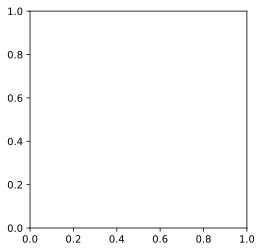

In [24]:
figure, axes = plt.subplots()
c = plt.Circle((0,0), 1, fill=False, color='k')
axes.set_aspect(1)
axes.plot(np.real(Lambda), np.imag(Lambda), 'k.')
#axes.plot(np.real(Lambdas), np.imag(Lambdas), 'r.')
axes.add_patch(c)
axes.set_xlabel(r'$\rm{Re}\, \lambda$')
axes.set_ylabel(r'$\rm{Im}\, \lambda$')

In [25]:
from scipy.stats import gaussian_kde
def f(x):
    kde = gaussian_kde(CVs[:,x])
    bounds = (CVs[:,x].min(),CVs[:,x].max())
    padding = 0
    cv_sample = np.linspace(bounds[0] - padding, bounds[1] + padding, 200)
    #print(kde.factor)
    plt.plot(cv_sample, -kde.logpdf(cv_sample), 'k-')
    plt.margins(0)
    plt.xlabel(f"Kernel_DMD_{x}")
    plt.ylabel(r"Fes $[K_{\rm{B}}T]$")
    print(kde.factor)
widgets.interact(f, x=widgets.IntSlider(min=0, max=CVs.shape[1] - 1, step=1, value=0));

interactive(children=(IntSlider(value=0, description='x', max=9), Output()), _dom_classes=('widget-interact',)…

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from stateinterpreter import Classifier, identify_metastable_states, load_dataframe, descriptors_from_traj, sample
from stateinterpreter.plot import plot_states, plot_combination_states_features
from stateinterpreter.visualize import visualize_features

In [38]:
chignolin_data_path = '../data/md_datasets/chignolin-unbiased/'
traj_dict = {
        'trajectory' : chignolin_data_path+'CLN025-0-protein-ALL.dcd',
        'topology' : chignolin_data_path+'CLN025-0-protein.pdb'
    }
stride = 25
#Compute descriptors
descriptors, feats_info = descriptors_from_traj(traj_dict, descriptors=['dihedrals'], stride=stride)

Descriptors: (20990, 102)


In [29]:
import pandas as pd
col_names = [f"Kernel_DMD_{idx}" for idx in range(CVs.shape[1])]
colvars = pd.DataFrame(CVs, columns=col_names)

DEV >>> Finding Local Minima
DEV >>> Basin Assignment
Found 3 local minima with selected populations:
	Basin 0 -> 483 configurations.
	Basin 1 -> 868 configurations.
	Basin 2 -> 9911 configurations.


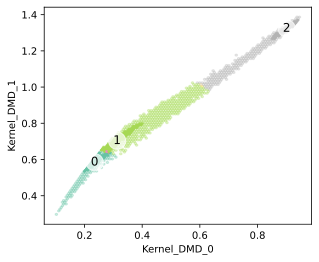

In [32]:
cv_list = ["Kernel_DMD_0","Kernel_DMD_1"]#, "Kernel_DMD_2"]
kBT = 2.8
states_labels = identify_metastable_states(colvars, cv_list, kBT, fes_cutoff=0.5*kBT, optimizer_kwargs={'num_init' : 50})
plot_states(colvars, states_labels, cv_list)

/home/novelli/md-stateinterpreter/stateinterpreter/descriptors.py:382: UserWarning: The asked number of samples is higher than the possible unique values. Sampling with replacement
  warn("The asked number of samples is higher than the possible unique values. Sampling with replacement")
Optimizing Lasso Estimator: 100%|██████████| 25/25 [00:00<00:00, 323.49it/s]


Accuracy: 65%
State 0:
[94.082%]  BACKBONE sin_psi GLU5
[3.818% ]  BACKBONE psi GLU5
[2.099% ]  BACKBONE cos_psi GLY7
State 1:
[94.082%]  BACKBONE sin_psi GLU5
[3.818% ]  BACKBONE psi GLU5
[2.099% ]  BACKBONE cos_psi GLY7


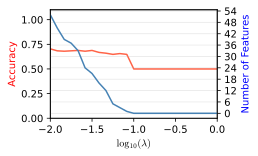

In [43]:
sample_obj, features_names, classes_names = sample(descriptors, states_labels, 500, states_subset=[0,1])
regularizers = np.geomspace(0.01, 1, 25)
classifier = Classifier(sample_obj, features_names, classes_names)
classifier.compute(regularizers, max_iter= 10000, quadratic_kernel=False)
classifier.plot();
reg = 10**(-1.2)
classifier.print_selected(reg)

In [44]:
visualize_features(traj[::stride], states_labels, classifier.classes, classifier._get_selected(reg), feats_info, state=0)

NGLWidget(max_frame=1)